# <center> Le mouvement Brownien fractionnaire

Le mouvement brownien fractionnaire (*fBm*) ou *fractional Brownian motion* en anglais, est un processus Gaussien en temps continu destiné à généraliser le mouvement brownien.

**Une définition possible du mouvement Brownien fractionnaire est donnée par :**

On se place sur un espace de probabilité $(\Omega, \mathcal{F}, \mathbb{P})$.

On dit que $X = (X_t)_{t \geq 0}$ est un mouvement brownien fractionnaire (réel, issu de 0) si $X$ est un processus gaussien centré ($\mathbb{E}[X_t] = 0, \forall t$) de covariance :

$$\forall s, t \in \mathbb{R}^+, \quad \mathbb{E}[X_t X_s] = \frac{1}{2} \left( |t|^{2H} + |s|^{2H} - |t-s|^{2H} \right)$$

et si, $\forall \omega \in \Omega, \quad t \longmapsto X_t(\omega)$ est continue sur $[0, +\infty[$,

avec $H \in ]0, 1]$, le paramètre de Hurst.

<br>

**Quelques propriétés du *fBm* :**

1. **Auto-similarité**: <br>Pour tout $a > 0$, la propriété d'auto-similarité est donnée par :
   $$(a^H X_{\frac{t}{a}})_{t \geq 0} \stackrel{d}{=} (X_t)_{t \geq 0}.$$
   Cela signifie que le processus est invariant sous un changement d'échelle approprié du temps et de l'espace.

2. **Stationnarité des incréments**:<br> Les incréments du fBm sont stationnaires et **dépendants** :
   $$X_{t+s} - X_s \stackrel{d}{=} X_t, \quad \forall s, t.$$

3. **Régularité**:<br> Les trajectoires du processus sont localement holderiennes d'exposant $\alpha < H$.<br><br>


Le paramètre $H$ joue un rôle double dans le comportement du processus :<br>
1. * Si $H < \frac{1}{2}$ : Corrélation négative à long terme : les mouvements positifs tendent à être suivis de mouvements négatifs et inversement.
   * Si $H = \frac{1}{2}$ : Pas de corrélation : on retrouve le mouvement Brownien classique (absence de mémoire).
   * Si $H > \frac{1}{2}$ : Corrélation positive à long terme : les mouvements positifs tendent à être suivis de mouvements positifs, et les mouvements négatifs tendent à être suivis de mouvements négatifs.<br>

Pour $H \neq \frac{1}{2}$, le processus n'est ni markovien, ni une semi-martingale.<br>

2. * Plus $H$ est proche de 1 et plus les valeurs du passée affectent les valeurs du futur (i.e plus la mémoire est impactante). Ceci a pour effet de diminuer la volatilité du processus / lisser ses trajectoires.
   * Au contraire, plus $H$ est proche de 0 et plus la corrélation négative des valeurs passées sur les valeurs futures est forte, ce qui a pour effet d'augmenter la volatilité du processus. Les trajectoires sont donc d'autant plus irrégulières que le paramètre $H$ s'approche de 0.

#### Simulation du fBm

L'idée est de discrétiser le temps et de simuler la loi du processus en chacun des points.

**Approche classique :**<br>
Comme le fBm est un processus Gaussien centré avec une matrice de covariance connue, on commence par simuler un vecteur Gaussien centré. Ensuite, on effectue une décomposition de Cholesky de la matrice de covariance pour en trouver sa racine carrée. En multipliant cette matrice racine par le vecteur Gaussien centré, on retrouve un vecteur Gaussien dont les corrélations correspondent à celles du fBm.<br>
**Coût computationnel pour générer m trajectoires de n points :** $O(n^3) + O(m*n^2)$<br>
Où le terme en $n^3$ provient de la décomposition de Cholesky et le terme en $m*n^2$ provient des $m$ multiplications d'un vecteur gaussien standard avec la matrice racine.

**Approche optimisée :**<br>:
Une approche plus optimisée repose sur la propriété d'accroissements stationnaires du processus. En effet, il existe un algorithme optimisé pour générer des trajectoires d'un processus gaussien stationnaire (reposant sur la structure particulière de la matrice de covariance). L'idée est donc de générer les accroissements puis de sommer pour retrouver les trajectoires du processus.<br>
**Coût computationnel pour générer m trajectoires de n points :** $O(m*n*log(n))$<br>

In [1]:
# Importation des librairies utiles
import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np

In [2]:
# Thème par défaut Seaborn : Amélioration de la lisibilité
sns.set_theme()

In [3]:
# Variables globales
rng = np.random.default_rng()

In [10]:
def cov_fbm(t, s, H):
    """
    Cette fonction permet de calculer la covariance E(X_t * X_s) où X est un mouvement brownien fractionnaire.

    :param t: Float
        Premier temps d'étude du processus.

    :param s: Float
        Second temps d'étude du processus.

    :param H: Float
        Nombre dans ]0, 1] : paramètre de Hurst.
    """
    return (1/2)*(np.power(s, 2*H) + np.power(t, 2*H) - np.power(np.abs(t-s), 2*H))


def simulate_fbm(size_path, size_sample, T, H):
    """
    Cette fonction permet de simuler les trajectoires d'un mouvement brownien fractionnaire (point par point via discrétisation du temps).
    
    :param size_path: Int
        Nombre de points pour lesquels la trajectoire sera simulée (excluant le point de départ donc size_path + 1 points par traj).

    :param size_sample: Int
        Nombre de trajectoires indépendantes à simuler.

    :param T: Float
        Durée totale de la période de simulation.

    :param H: Float
        Paramètre de Hurst dans ]0, 1].

    :return: np.array
        Un tableau numpy de dimensions (size_path + 1, size_sample) contenant les trajectoires simulées de l'actif. 
        La première dimension représente le temps (avec size_path + 1 points temporels, incluant le point de départ), 
        et la seconde dimension représente les différentes trajectoires simulées.

    Remarque: Cette fonction nécessite la variable globale rng = numpy.random.default_rng().
    """
    # Tirage du vecteur gaussien centré
    gauss = rng.standard_normal(size=(size_path, size_sample))

    # Construction de la matrice de covariance
    time = np.linspace(start=0, stop=T, num=size_path+1)[1:]  # Grille temporelle : +1 pour inclure T, [1:] pour exclure 0 (le processus commence en 0). Pas de temps de 1/size_path
    
    cov = cov_fbm(time[:, np.newaxis], time[np.newaxis, :], H)  # Broadcasting numpy pour l'optimisation
    try:
        L = np.linalg.cholesky(cov)
    except np.linalg.LinAlgError as e:
        print("Erreur lors du calcul de la décomposition de Cholesky :", str(e))
        raise ValueError  # Ne devrait pas arriver, la matrice est semie définie positive...

    gauss = L @ gauss
    
    fbm = np.zeros(shape=(size_path+1, size_sample))
    fbm[1:] = gauss

    return fbm

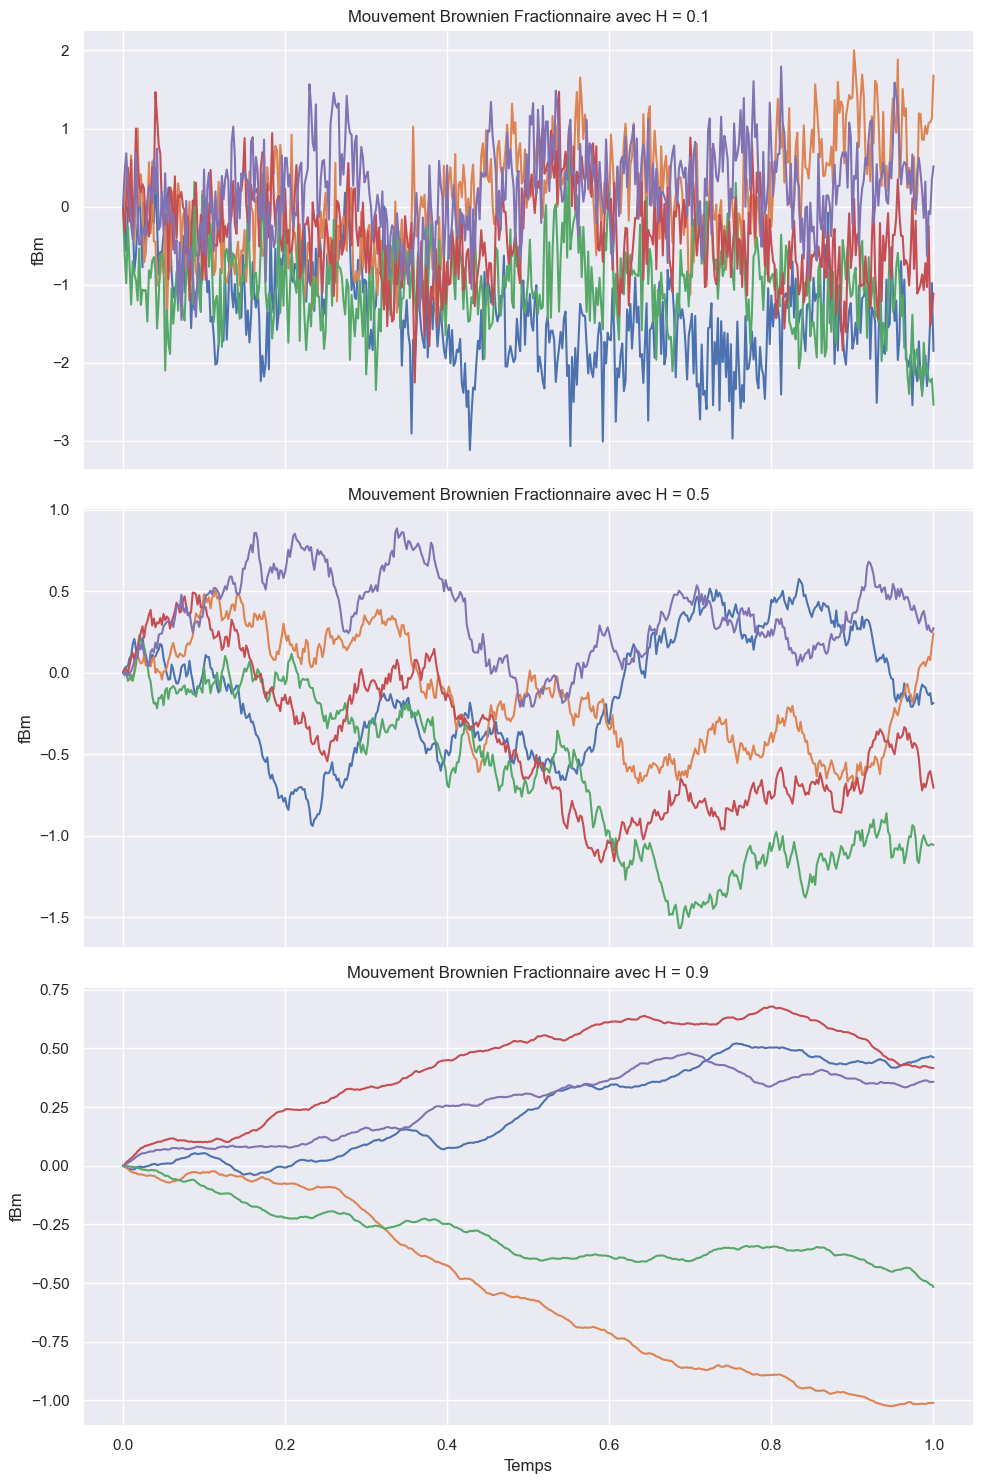

In [12]:
# Affichage de quelques trajectoires
T = 1
n = 500
hurst_params = [0.1, 0.5, 0.9]
m = 5

times = np.linspace(start=0, stop=T, num=n+1)

# Création des graphiques
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15), sharex=True)

for i, H in enumerate(hurst_params):
    paths = simulate_fbm(n, m, T, H)
    for j in range(m):
        axes[i].plot(times, paths[:, j], label=f'H = {H}')
    axes[i].set_title(f'Mouvement Brownien Fractionnaire avec H = {H}')
    axes[i].set_ylabel('fBm')
    axes[i].grid(True)

axes[-1].set_xlabel('Temps')

plt.tight_layout()
plt.show()

Pistes de recherches / simulations possibles :
- Remplacer le mouvement brownien par un mouvement brownien fractionnaire dans quelques modèles classiques (Black Scholes, Heston...) et visualiser l'impact du paramètre de Hurst dans le cadre du pricing de contrat d'options.
  
  -> Je m'attends à ce que plus H se rapproche de 1 et plus le prix des contrats est bas car on contrôle mieux l'aléatoire grâce à la propriété d'auto-corrélation positive des accroissements. Par contre quid du cas où H est proche de 0 ? Est-ce qu'une corrélation négative apporte plus d'aléatoire qu'aucune corrélation ? ==> Je dirais que oui car comme la volatilité du processus augmente lorsque le paramètre de Hurst se rapproche de 0, l'incertitude augmente et avec elle le prix du contrat.
  
- Comparer l'efficacité / l'erreur du calibrage des modèles classiques contre les modèles avec fBm sur la volatilité historique des marchés d'options (ex: SPX).

### Ressources

Exercice Sheet - Simulation of Fractional Brownian Motion, Paul P. Hager <br>https://hagerpa.github.io/talks/excersize_sheet_sampling_of_fBm.pdf <br><br>https://en.wikipedia.org/wiki/Fractional_Brownian_motion<br>
<br>Simulation of fractional Brownian motion<br>https://www.columbia.edu/~ad3217/fbm/thesis.pdf